In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import random
import seaborn as sns
import sklearn.metrics as sk

from collections import Counter

In [2]:
def pre_processamento():
    #xlsx = pd.ExcelFile('casos_corona.xlsx')
    #df = pd.read_excel(xlsx, 'casos_corona')
    xlsx = pd.ExcelFile('coronga_atualizado.xlsx')
    df = pd.read_excel(xlsx, 'casos_coronavirus')
    df = df
    df = df[['bairroPaciente','municipioPaciente','resultadoFinalExame','sexoPaciente', 'idadePaciente']]
    
    novo_df = []
    for i in range(len(df)):
        if(df.loc[i][2] == 'Positivo'):
            resultado = 1
            novo_df.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3], df.loc[i][4]])
        else:
            resultado = 0
            novo_df.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3], df.loc[i][4]])
    
    novo_df = pd.DataFrame(novo_df)
    novo_df.rename(columns={0: 'bairro_paciente', 1: 'municipio_paciente', 2: 'resultado_exame', 3: 'sexo_paciente', 4: 'idade_paciente'}, inplace=True)    
    return novo_df

In [3]:
df = pre_processamento()
df

,bairro_paciente,municipio_paciente,resultado_exame,sexo_paciente,idade_paciente
0,MONSENHOR SABINO,ACARAU,1,FEMININO,62
1,LAGOA DO MATO,ITATIRA,1,MASCULINO,18
2,CROATA II,PACAJUS,1,FEMININO,24
3,ZONA RURAL,NOVO ORIENTE,0,FEMININO,30
4,CENTRO,TIANGUA,0,MASCULINO,47
5,ROBERTO DOURADO,URUOCA,0,FEMININO,37
6,PRECABURA,EUSEBIO,0,FEMININO,21
7,COCO,FORTALEZA,0,FEMININO,54
8,PAJUÇARA,MARACANAU,0,FEMININO,34
9,ANTONIO HOLANDA,LIMOEIRO DO NORTE,1,FEMININO,21


In [4]:
#df.groupby(['resultado_exame']).describe()

In [5]:
def agrupar_idade(df):
    clusters_idades = []
    idade_max = max(df['idade_paciente'])

    for x in range(0,5):
        if((idade_max+x)%5 == 0):
            dif = x

    intervalos = np.arange(1, idade_max+dif+1, dtype=int)

    for i in range(0, int(idade_max+dif), 5):
        gaps = []
        for j in range(i, i+5):
            gaps.append(intervalos[j])
        clusters_idades.append(gaps)
    clusters_idades

    casos_idade = []

    for cluster in clusters_idades:
        count = 0
        for i in range(len(df)):
            if(df.loc[i][4] in cluster and df.loc[i][2] == 1):
                count = count + 1
        casos_idade.append(['[{}:{}]'.format(cluster[0], cluster[4]), count])
    casos_idade = pd.DataFrame(casos_idade)
    casos_idade.rename(columns={0: 'idade', 1: 'count'}, inplace=True)
    casos_idade = casos_idade.sort_values(by=['count'], ascending=True)
    ordem = np.arange(1,len(casos_idade)+1)
    casos_idade['ordem'] = pd.Series(ordem, index=casos_idade.index)
    return casos_idade

In [6]:
dataset_idade = agrupar_idade(df)
dataset_idade

,idade,count,ordem
1,[6:10],865,1
0,[1:5],908,2
17,[86:90],1136,3
2,[11:15],1230,4
16,[81:85],1986,5
15,[76:80],2556,6
3,[16:20],2604,7
14,[71:75],3337,8
13,[66:70],3885,9
12,[61:65],4520,10


In [7]:
def top_k_reverse_idade(dataset, k):
    copia = dataset.copy()
    output = []
    for i in range(k):
        indice = copia['count'].idxmin()
        output.append([copia.loc[indice][0], copia.loc[indice][1]])
        copia.drop(indice, inplace=True,axis=0)
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'idade', 1: 'count'})
    return output

In [8]:
top_k_reverse_idade(dataset_idade, 10)

,idade,count
0,[6:10],865
1,[1:5],908
2,[86:90],1136
3,[11:15],1230
4,[81:85],1986
5,[76:80],2556
6,[16:20],2604
7,[71:75],3337
8,[66:70],3885
9,[61:65],4520


# Ruído de Laplace

In [9]:
def sensibilidade_lap(dataset, budget, k):
    smooth_functions = [1]*len(dataset['count'])
    beta = budget/k
    otimo = 0
    for smooth in smooth_functions:
        otimo = max(otimo, (smooth*math.exp(-beta)))
    return otimo

In [10]:
def plot_erros(erros_argumento, k, metodo):
    df = pd.DataFrame({
        'epsilon': ['0.01', '0.1', '0.5', '1', '1.5', '2'],
        'F1 Score': erros_argumento })
    sns.catplot(x="epsilon", y="F1 Score", palette="ch:.5",
                data=df, saturation=.7,
                kind="bar", ci=None, aspect=.9, order=['0.01', '0.1', '0.5', '1', '1.5', '2'])

    plt.title("Média utilizando a métrica F1 Score para {}".format(metodo))
    plt.xlabel("Epsilon")
    plt.ylabel("F1 Score, k = {}".format(k))
    return plt.show()

In [11]:
#usando biblioteca
def f1_score(query, argumento_consulta, budgets):
    y_true = []
    for i in range(len(query)):
        if(query['idade'][i][2] != ':'):
            y_true.append(query['idade'][i][1:3])
        else:
            y_true.append(query['idade'][i][1])
    
    idades_t = pd.DataFrame(argumento_consulta)
    y_pred = []
    for i in range(len(idades_t)):
        linha = []
        for j in range(len(idades_t.loc[0])):
            if(idades_t.loc[i][j][2] != ':'):
                linha.append(idades_t.loc[i][j][1:3])
            else:
                linha.append(idades_t.loc[i][j][1])
        y_pred.append(linha)
    
    metrica = []
    for row in range(len(budgets)):
        metrica.append(sk.f1_score(y_true, y_pred[row], average='macro'))
    
    return metrica

# Consulta Idade com ruído

In [12]:
def laplace_idade(budget, sensibilidade, query, dataset, k):
    resposta_query = np.array(query['count'])
    coluna_idades = np.array(query['idade'])
    output = []
    #np.random.seed(7)
    for i in range(k):
        ruido = stats.laplace.rvs(loc = 0, scale = sensibilidade/budget)
        output.append((resposta_query[i] + ruido))
    output = {
        'idade': coluna_idades,
        'count': output
    }
    
    df = pd.DataFrame(output, columns = ['idade', 'count'])
    return df.sort_values(by=['count'],ascending=True)

In [27]:
budgets = [0.01, 0.1, 0.5, 1, 1.5, 2]
idades = []
k = 10
for budget in budgets:
    a = laplace_idade(budget, sensibilidade_lap(dataset_idade, budget, 10), top_k_reverse_idade(dataset_idade, 10), dataset_idade, 10)
    a = np.array(a)
    print("epsilon: {}\nreverse top-k:\n{}\n\n".format(budget, a))
    idades.append(a[:,0])

epsilon: 0.01
reverse top-k:
[['[1:5]' 705.4447754783469]
 ['[6:10]' 1000.359415193169]
 ['[11:15]' 1079.407024548985]
 ['[86:90]' 1252.3354993858131]
 ['[81:85]' 2238.4152095665513]
 ['[16:20]' 2470.148581457587]
 ['[76:80]' 2507.991758195243]
 ['[71:75]' 3352.6079002004362]
 ['[66:70]' 3897.477879417411]
 ['[61:65]' 4452.739278291061]]


epsilon: 0.1
reverse top-k:
[['[6:10]' 861.9236156008058]
 ['[1:5]' 924.3930417171574]
 ['[86:90]' 1139.4506286854503]
 ['[11:15]' 1228.3050976965526]
 ['[81:85]' 1980.3741912757534]
 ['[76:80]' 2560.9450736410417]
 ['[16:20]' 2603.36164661371]
 ['[71:75]' 3331.3624502948933]
 ['[66:70]' 3889.324785154261]
 ['[61:65]' 4523.277773532592]]


epsilon: 0.5
reverse top-k:
[['[6:10]' 868.7060640957899]
 ['[1:5]' 909.624244825174]
 ['[86:90]' 1138.544286312591]
 ['[11:15]' 1225.533388727874]
 ['[81:85]' 1983.825440363017]
 ['[76:80]' 2551.8525378415693]
 ['[16:20]' 2598.29739686134]
 ['[71:75]' 3336.949395845342]
 ['[66:70]' 3884.355671382133]
 ['[61:65]' 4

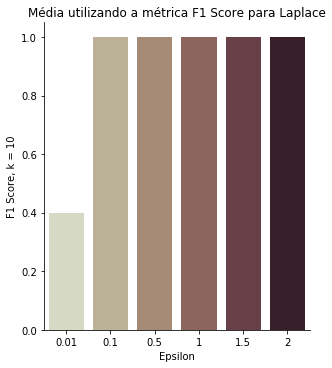

In [28]:
query_idades = top_k_reverse_idade(dataset_idade, 10)
metodo = 'Laplace'
f1_lap = f1_score(query_idades, idades, budgets)
plot_erros(f1_lap, 10, metodo)

# Mecanismo Exponencial

In [15]:
def score_function_exp(dataset):
    return -dataset['count']

In [56]:
def sensibilidade_exp(dataset, budget, k):
    smooth_functions = [1]*len(dataset['count'])
    beta = budget/k
    otimo = 0
    for smooth in smooth_functions:
        otimo = max(otimo, (smooth*math.exp(-beta)))
    return otimo

# Consulta Idade Exponencial

In [57]:
def exp_idades(budget, sensibilidade, dataset, k):
    budget = budget/k

    scores = score_function_exp(dataset)

    _users = list(dataset['idade'].copy())
    _scores = list(scores.copy())
    counts = list(dataset['count'].copy())

    top = []

    for i_run in range(k):

        probabilities = []

        for j_score in _scores:
            probability = math.exp( (budget * j_score) / (2 * sensibilidade) )
            probabilities.append(probability)

        probabilities = [j_probability/sum(probabilities) for j_probability in probabilities]

        sample = random.choices(population=_users, weights=probabilities, k=1)[0]
        
        count = counts[_users.index(sample)]

        top.append([sample, count])

        _scores.remove(_scores[_users.index(sample)])
        _users.remove(sample)
        counts.remove(count)

    return top

In [58]:
idades_exp = []

for budget in budgets:
    b = exp_idades(budget, sensibilidade_exp(dataset_idade, budget, 10), dataset_idade, 10)
    b = np.array(b)
    print("epsilon: {}\nreverse top-k:\n{}\n\n".format(budget, b))
    idades_exp.append(b[:,0])

epsilon: 0.01
reverse top-k:
[['[81:85]' '1986']
 ['[1:5]' '908']
 ['[86:90]' '1136']
 ['[6:10]' '865']
 ['[76:80]' '2556']
 ['[11:15]' '1230']
 ['[71:75]' '3337']
 ['[21:25]' '5674']
 ['[46:50]' '6875']
 ['[61:65]' '4520']]


epsilon: 0.1
reverse top-k:
[['[6:10]' '865']
 ['[11:15]' '1230']
 ['[1:5]' '908']
 ['[86:90]' '1136']
 ['[81:85]' '1986']
 ['[16:20]' '2604']
 ['[76:80]' '2556']
 ['[71:75]' '3337']
 ['[66:70]' '3885']
 ['[61:65]' '4520']]


epsilon: 0.5
reverse top-k:
[['[1:5]' '908']
 ['[6:10]' '865']
 ['[86:90]' '1136']
 ['[11:15]' '1230']
 ['[81:85]' '1986']
 ['[76:80]' '2556']
 ['[16:20]' '2604']
 ['[71:75]' '3337']
 ['[66:70]' '3885']
 ['[61:65]' '4520']]


epsilon: 1
reverse top-k:
[['[6:10]' '865']
 ['[1:5]' '908']
 ['[86:90]' '1136']
 ['[11:15]' '1230']
 ['[81:85]' '1986']
 ['[76:80]' '2556']
 ['[16:20]' '2604']
 ['[71:75]' '3337']
 ['[66:70]' '3885']
 ['[61:65]' '4520']]


epsilon: 1.5
reverse top-k:
[['[6:10]' '865']
 ['[1:5]' '908']
 ['[86:90]' '1136']
 ['[11:15]' '1

In [59]:
idades_exp

[array(['[81:85]', '[1:5]', '[86:90]', '[6:10]', '[76:80]', '[11:15]',
        '[71:75]', '[21:25]', '[46:50]', '[61:65]'], dtype='<U7'),
 array(['[6:10]', '[11:15]', '[1:5]', '[86:90]', '[81:85]', '[16:20]',
        '[76:80]', '[71:75]', '[66:70]', '[61:65]'], dtype='<U7'),
 array(['[1:5]', '[6:10]', '[86:90]', '[11:15]', '[81:85]', '[76:80]',
        '[16:20]', '[71:75]', '[66:70]', '[61:65]'], dtype='<U7'),
 array(['[6:10]', '[1:5]', '[86:90]', '[11:15]', '[81:85]', '[76:80]',
        '[16:20]', '[71:75]', '[66:70]', '[61:65]'], dtype='<U7'),
 array(['[6:10]', '[1:5]', '[86:90]', '[11:15]', '[81:85]', '[76:80]',
        '[16:20]', '[71:75]', '[66:70]', '[61:65]'], dtype='<U7'),
 array(['[6:10]', '[1:5]', '[86:90]', '[11:15]', '[81:85]', '[76:80]',
        '[16:20]', '[71:75]', '[66:70]', '[61:65]'], dtype='<U7')]

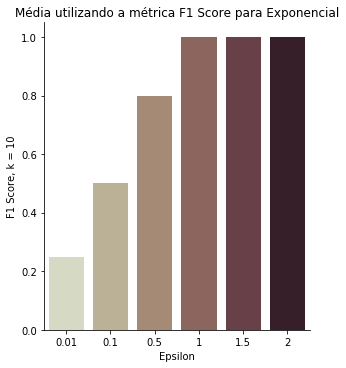

In [60]:
metodo = 'Exponencial'
f1 = f1_score(query_idades, idades_exp, budgets)
plot_erros(f1, 10, metodo)

# Calculando a média dos valores para cada epsilon
## Pros resultados não serem aleatórios

### Laplace

In [21]:
aux_lap = []
query_idades = top_k_reverse_idade(dataset_idade, 10)
for i in range(10):
    lista_lap = []
    for eps in budgets:
        res = np.array(laplace_idade(eps, sensibilidade_lap(dataset_idade, eps, 10), top_k_reverse_idade(dataset_idade, 10), dataset_idade, 10))
        lista_lap.append(res[:, 0])
    f1_lap = f1_score(query_idades, lista_lap, budgets)
    aux_lap.append(f1_lap)
aux_lap

[[0.4, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.6, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.7, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.8, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.8, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.6, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.6, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.8, 0.8, 1.0, 1.0, 1.0, 1.0]]

In [22]:
lista_de_listas = []
for i in range(len(aux_lap[0])):
    listinha = []
    for j in range(len(aux_lap)):
        listinha.append(aux_lap[j][i])
    lista_de_listas.append(listinha)
medias_lap = [0]*len(lista_de_listas)
for i in range(len(lista_de_listas)):
    medias_lap[i] = np.mean(lista_de_listas[i])
medias_lap

[0.73, 0.9800000000000001, 1.0, 1.0, 1.0, 1.0]

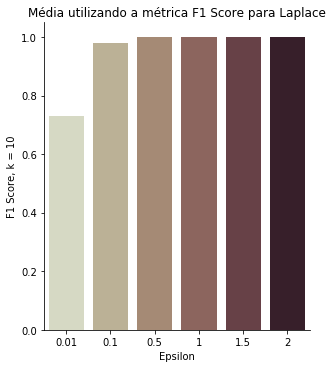

In [23]:
metodo = 'Laplace'
plot_erros(medias_lap, 10, metodo)

### Exponencial

In [24]:
aux = []
for i in range(10):
    lista = []
    for eps in budgets:
        hm = np.array(exp_idades(eps, sensibilidade_exp(dataset_idade, eps, 10), dataset_idade, 10))
        lista.append(hm[:,0])
    f1 = f1_score(query_idades, lista, budgets)
    aux.append(f1)
aux

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[[0.08333333333333333, 0.7, 1.0, 1.0, 1.0, 1.0],
 [0.3, 0.6, 0.8, 1.0, 1.0, 1.0],
 [0.09090909090909091, 0.8, 1.0, 1.0, 1.0, 1.0],
 [0.08333333333333333, 0.4, 0.8, 1.0, 1.0, 1.0],
 [0.09090909090909091, 0.5, 1.0, 1.0, 1.0, 1.0],
 [0.2727272727272727, 0.4, 1.0, 1.0, 1.0, 1.0],
 [0.0, 0.8, 1.0, 1.0, 1.0, 1.0],
 [0.25, 0.6, 0.8, 1.0, 1.0, 1.0],
 [0.09090909090909091, 0.6, 0.8, 1.0, 1.0, 1.0],
 [0.09090909090909091, 0.8, 0.8, 0.8, 1.0, 1.0]]

In [25]:
que = []
for i in range(len(aux[0])):
    mano = []
    for j in range(len(aux)):
        mano.append(aux[j][i])
    que.append(mano)
medias = [0]*len(que)
for i in range(len(que)):
    medias[i] = np.mean(que[i])
medias

[0.1353030303030303,
 0.6199999999999999,
 0.9000000000000001,
 0.9800000000000001,
 1.0,
 1.0]

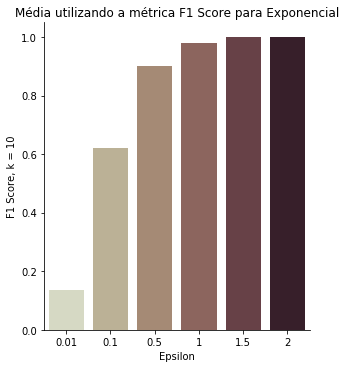

In [26]:
metodo = 'Exponencial'
plot_erros(medias, 10, metodo)